## TF GAN

In [ ]:
import tensorflow as tf
tf.enable_eager_execution()

from glob import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from keras.preprocessing import image

from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!find . -type f -iname \*.png -delete

In [ ]:
!unzip './gdrive/My Drive/scripts/simpsons/cropped.zip' -d './simpsons'

In [ ]:
def read_images(file_path, ext='png'):
    pics = glob(file_path + "/*." + ext)
    images = []
    images_1 = []
    for pic in pics[:2000]:
#         images.append(image.img_to_array(PIL.Image.open(pic).convert('RGB')))
        images_1.append(image.img_to_array(PIL.Image.open(pic).convert('RGB')))
        images.append(image.img_to_array(PIL.Image.open(pic).resize((128,128))) / 127.5 - 1)
    return images, images_1

In [ ]:
images, see = read_images('./simpsons/')


In [ ]:
plt.imshow(images[1])

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generator(z, output_channel_dim, training):
    with tf.variable_scope("generator", reuse= not training):
        
        # 8x8x1024
        fully_connected = tf.layers.dense(z, 8*8*1024)
        fully_connected = tf.reshape(fully_connected, (-1, 8, 8, 1024))
        fully_connected = tf.nn.leaky_relu(fully_connected)

        # 8x8x1024 -> 16x16x512
        trans_conv1 = tf.layers.conv2d_transpose(inputs=fully_connected,
                                                 filters=512,
                                                 kernel_size=[KSIZE,KSIZE],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv1")
        batch_trans_conv1 = tf.layers.batch_normalization(inputs = trans_conv1,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv1")
        trans_conv1_out = tf.nn.leaky_relu(batch_trans_conv1,
                                           name="trans_conv1_out")
        
        # 16x16x512 -> 32x32x256
        trans_conv2 = tf.layers.conv2d_transpose(inputs=trans_conv1_out,
                                                 filters=256,
                                                 kernel_size=[KSIZE,KSIZE],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv2")
        batch_trans_conv2 = tf.layers.batch_normalization(inputs = trans_conv2,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv2")
        trans_conv2_out = tf.nn.leaky_relu(batch_trans_conv2,
                                           name="trans_conv2_out")
        
        # 32x32x256 -> 64x64x128
        trans_conv3 = tf.layers.conv2d_transpose(inputs=trans_conv2_out,
                                                 filters=128,
                                                 kernel_size=[KSIZE,KSIZE],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv3")
        batch_trans_conv3 = tf.layers.batch_normalization(inputs = trans_conv3,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv3")
        trans_conv3_out = tf.nn.leaky_relu(batch_trans_conv3,
                                           name="trans_conv3_out")
        
        # 64x64x128 -> 128x128x64
        trans_conv4 = tf.layers.conv2d_transpose(inputs=trans_conv3_out,
                                                 filters=64,
                                                 kernel_size=[KSIZE,KSIZE],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv4")
        batch_trans_conv4 = tf.layers.batch_normalization(inputs = trans_conv4,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv4")
        trans_conv4_out = tf.nn.leaky_relu(batch_trans_conv4,
                                           name="trans_conv4_out")
        
        # 128x128x64 -> 128x128x3
        logits = tf.layers.conv2d_transpose(inputs=trans_conv4_out,
                                            filters=4,
                                            kernel_size=[KSIZE,KSIZE],
                                            strides=[1,1],
                                            padding="SAME",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                            name="logits")
        out = tf.tanh(logits, name="out")
        return out

def discriminator(x, reuse):
    with tf.variable_scope("discriminator", reuse=reuse): 
        
        # 128*128*3 -> 64x64x64 
        conv1 = tf.layers.conv2d(inputs=x,
                                 filters=64,
                                 kernel_size=[KSIZE,KSIZE],
                                 strides=[2,2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv1')
        batch_norm1 = tf.layers.batch_normalization(conv1,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm1')
        conv1_out = tf.nn.leaky_relu(batch_norm1,
                                     name="conv1_out")
        
        # 64x64x64-> 32x32x128 
        conv2 = tf.layers.conv2d(inputs=conv1_out,
                                 filters=128,
                                 kernel_size=[KSIZE,KSIZE],
                                 strides=[2, 2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv2')
        batch_norm2 = tf.layers.batch_normalization(conv2,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm2')
        conv2_out = tf.nn.leaky_relu(batch_norm2,
                                     name="conv2_out")
        
        # 32x32x128 -> 16x16x256  
        conv3 = tf.layers.conv2d(inputs=conv2_out,
                                 filters=256,
                                 kernel_size=[KSIZE,KSIZE],
                                 strides=[2, 2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv3')
        batch_norm3 = tf.layers.batch_normalization(conv3,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm3')
        conv3_out = tf.nn.leaky_relu(batch_norm3,
                                     name="conv3_out")
        
        # 16x16x256 -> 16x16x512
        conv4 = tf.layers.conv2d(inputs=conv3_out,
                                 filters=512,
                                 kernel_size=[KSIZE,KSIZE],
                                 strides=[1, 1],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv4')
        batch_norm4 = tf.layers.batch_normalization(conv4,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm4')
        conv4_out = tf.nn.leaky_relu(batch_norm4,
                                     name="conv4_out")
        
        # 16x16x512 -> 8x8x1024
        conv5 = tf.layers.conv2d(inputs=conv4_out,
                                filters=1024,
                                kernel_size=[KSIZE,KSIZE],
                                strides=[2, 2],
                                padding="SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                name='conv5')
        batch_norm5 = tf.layers.batch_normalization(conv5,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm5')
        conv5_out = tf.nn.leaky_relu(batch_norm5,
                                     name="conv5_out")

        flatten = tf.reshape(conv5_out, (-1, 8*8*1024))
        logits = tf.layers.dense(inputs=flatten,
                                 units=1,
                                 activation=None)
        out = tf.sigmoid(logits)
        return out, logits

def model_loss(input_real, input_z, output_channel_dim):
    g_model = generator(input_z, output_channel_dim, True)

    noisy_input_real = input_real + tf.random_normal(shape=tf.shape(input_real),
                                                     mean=0.0,
                                                     stddev=random.uniform(0.0, 0.1),
                                                     dtype=tf.float32)
    
    d_model_real, d_logits_real = discriminator(noisy_input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*random.uniform(0.9, 1.0)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = tf.reduce_mean(0.5 * (d_loss_real + d_loss_fake))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss

def model_optimizers(d_loss, g_loss):
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=LR_D, beta1=BETA1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=LR_G, beta1=BETA1).minimize(g_loss, var_list=g_vars)  
    return d_train_opt, g_train_opt

def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate_G = tf.placeholder(tf.float32, name="lr_g")
    learning_rate_D = tf.placeholder(tf.float32, name="lr_d")
    return inputs_real, inputs_z, learning_rate_G, learning_rate_D

def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (12, 10))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
        image.save(name+"_"+str(epoch)+"_"+str(index)+".png") 
    plt.savefig(name+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

def test(sess, input_z, out_channel_dim, epoch):
    example_z = np.random.uniform(-1, 1, size=[SAMPLES_TO_SHOW, input_z.get_shape().as_list()[-1]])
    samples = sess.run(generator(input_z, out_channel_dim, False), feed_dict={input_z: example_z})
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, OUTPUT_DIR + "samples", epoch)

def summarize_epoch(epoch, duration, sess, d_losses, g_losses, input_z, data_shape):
    minibatch_size = int(data_shape[0]//BATCH_SIZE)
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-minibatch_size:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-minibatch_size:])))
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    test(sess, input_z, data_shape[3], epoch)

def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = Image.fromarray(img)
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return batches

def train(get_batches, data_shape, checkpoint_to_load=None):
    input_images, input_z, lr_G, lr_D = model_inputs(data_shape[1:], NOISE_SIZE)
    d_loss, g_loss = model_loss(input_images, input_z, data_shape[3])
    d_opt, g_opt = model_optimizers(d_loss, g_loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        epoch = 0
        iteration = 0
        d_losses = []
        g_losses = []
        
        for epoch in range(EPOCHS):        
            epoch += 1
            start_time = time.time()

            for batch_images in get_batches:
                iteration += 1
                batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
                _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: LR_D})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: LR_G})
                d_losses.append(d_loss.eval({input_z: batch_z, input_images: batch_images}))
                g_losses.append(g_loss.eval({input_z: batch_z}))

            summarize_epoch(epoch, time.time()-start_time, sess, d_losses, g_losses, input_z, data_shape)



In [11]:
INPUT_DATA_DIR = "../input/pokemon-images-dataset/pokemon/pokemon/"
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [18]:
IMAGE_SIZE = 128
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 64
KSIZE = 5
EPOCHS = 1 # For better results increase this value 
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 2

Start!
Input: (819, 128, 128, 4)


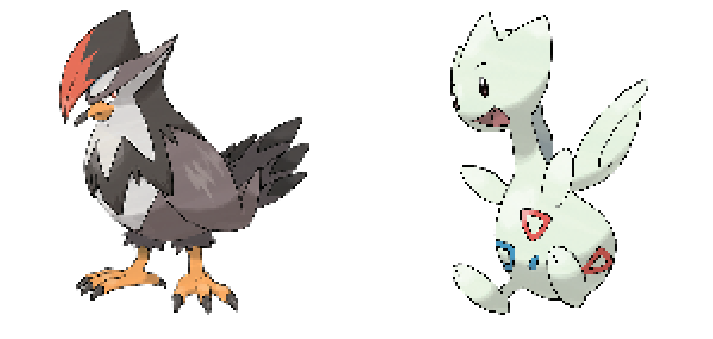

Epoch 1/1 
Duration: 12.62643 
D Loss: 7.06098 
G Loss: 0.00010


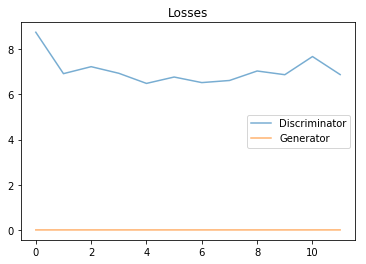

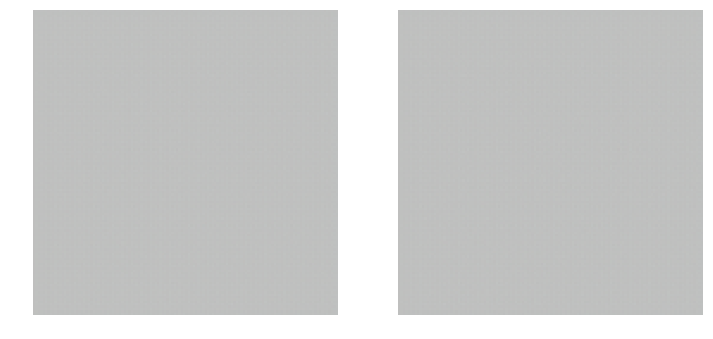

In [19]:
# Training
print("Start!")
input_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) for file in glob(INPUT_DATA_DIR + '*')])
print ("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

sample_images = random.sample(list(input_images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)

with tf.Graph().as_default():
    train(get_batches(input_images), input_images.shape)

In [ ]:
BUFFER_SIZE = 20
BATCH_SIZE = 4

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
type(train_dataset)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((8, 8, 128)))
    assert model.output_shape == (None, 8, 8, 128) # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

#     model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 32, 32, 64)  
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
    
#     model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 64, 64, 128)  
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
    
#     model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 128, 128, 64)  
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
    
#     model.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 256, 256, 32)  
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 3), model.output_shape
  
    return model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model



In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [ ]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [ ]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [ ]:
generator_optimizer = tf.train.AdamOptimizer(1e-3)
discriminator_optimizer = tf.train.AdamOptimizer(1e-3)


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 4

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [ ]:
def train_step(images):
   # generating noise from a normal distribution
    noise = tf.random_normal([BATCH_SIZE, noise_dim])
      
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [ ]:
train_step = tf.contrib.eager.defun(train_step)

In [ ]:
def train(dataset, epochs):  
    for epoch in range(epochs):
        start = time.time()
    
        for images in dataset:
            train_step(images)

        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                   epoch + 1,
                                   random_vector_for_generation)

        # saving (checkpoint) the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                          time.time()-start))
  # generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
    predictions = model(test_input, training=False)
#     print(predictions.shape)
#     print(predictions.dtype)
    fig = plt.figure(figsize=(16,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(1, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
#     if epoch % 5 == 0:
    plt.show()

In [ ]:
%%time
train(train_dataset, EPOCHS)

In [ ]:
predictions